In [1]:
pip install pandas numpy sklearn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set 

In [2]:
kernel

NameError: name 'kernel' is not defined

In [4]:
11+22

33

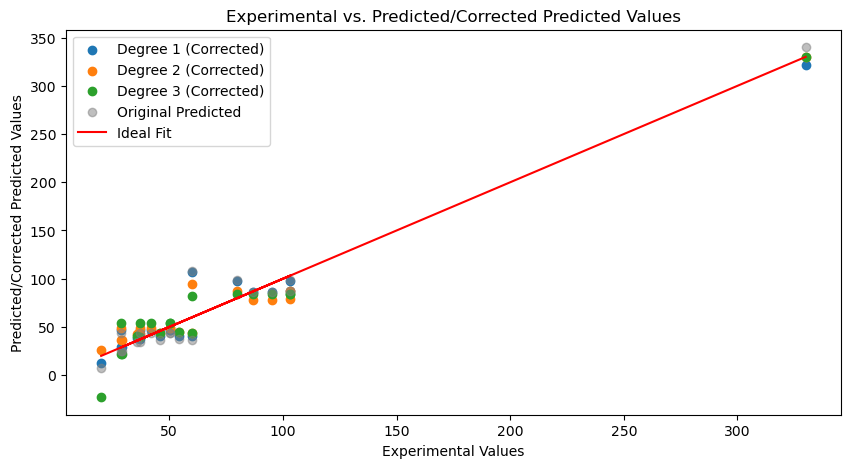

In [94]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Load data from Excel file
file_path = 'experimental_data.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, names=['Predicted', 'Experimental'], skiprows=1)

# Define bin edges for groups
bins = [0, 10, 50, 100, 500, 1000]

def categorize_data(data, bins):
    categories = pd.cut(data, bins=bins, labels=[1, 2, 3, 4, 5], include_lowest=True)
    return categories

df['Predicted_Group'] = categorize_data(df['Predicted'], bins)
df['Experimental_Group'] = categorize_data(df['Experimental'], bins)

df['Fold_Difference'] = df.apply(lambda x: max(x['Predicted']/x['Experimental'], x['Experimental']/x['Predicted']), axis=1)
df['Value_Difference'] = abs(df['Predicted'] - df['Experimental'])

group_outliers = (abs(df['Predicted_Group'].cat.codes - df['Experimental_Group'].cat.codes) > 2)
value_outliers = ((df['Predicted'] > 20) & (df['Fold_Difference'] > 2)) | ((df['Predicted'] <= 20) & (df['Value_Difference'] > 10))
total_outliers = group_outliers | value_outliers

outliers_to_remove = total_outliers.sum()
total_data = len(df)
max_outliers = total_data - int(0.7 * total_data)  
outlier_indices = df[total_outliers].nlargest(max_outliers, 'Value_Difference').index
df = df.drop(outlier_indices)

X = df[['Predicted']]
y = df['Experimental']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

top_models = []

for degree in range(1, 4):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    top_models.append({
        'degree': degree,
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': rmse,
        'equation': f'y = {model.named_steps["linearregression"].coef_[1]:.4f}x + {model.named_steps["linearregression"].intercept_:.4f}'
    })

# Sort and select the top 3 models by test R^2
top_models = sorted(top_models, key=lambda x: x['test_r2'], reverse=True)[:3]

# Visualize results
plt.figure(figsize=(10, 5))
for model_info in top_models:
    y_pred = model_info['model'].predict(X)
    plt.scatter(y, y_pred, label=f'Degree {model_info["degree"]} (Corrected)')
plt.scatter(y, df['Predicted'], color='grey', alpha=0.5, label='Original Predicted')
plt.plot(y, y, 'r-', label='Ideal Fit')
plt.title('Experimental vs. Predicted/Corrected Predicted Values')
plt.xlabel('Experimental Values')
plt.ylabel('Predicted/Corrected Predicted Values')
plt.legend()
plt.show()

# Save details and results
with pd.ExcelWriter('enhanced_model_performance.xlsx') as writer:
    for i, model in enumerate(top_models):
        results_df = pd.DataFrame({
            'Experimental': y,
            'Predicted': df['Predicted'],
            'Corrected Predicted': model['model'].predict(X),
            'Train R^2': model['train_r2'],
            'Test R^2': model['test_r2'],
            'RMSE': model['rmse'],
            'Equation': model['equation']
        })
        results_df.to_excel(writer, sheet_name=f'Model_{model["degree"]}_Details')
